In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator
from glob import glob
from tqdm import tqdm
from pathlib import Path
from keras.models import Sequential, model_from_json
from keras.layers import Activation, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten, GlobalMaxPooling2D
from sklearn.model_selection import train_test_split
from PIL import Image
import os
from tensorboard import notebook
import datetime

In [3]:
%load_ext tensorboard

# Parameters

In [4]:
# input
INPUT = Path(r'D:\ML Datasets\kagglecatsanddogs_5340')
OUTPUT_MODEL = Path(r'C:\Users\jean-\OneDrive\Documentos\DSProject\Cats And Dogs Classifier\Models')
SPLIT = Path(r'D:\ML Datasets\kagglecatsanddogs_5340\Split')
DIM = 'Color'
IMG_WIDTH, IMG_HEIGHT = 256, 256
RESCALE_IMG_WIDTH, RESCALE_IMG_HEIGHT = 128, 128
BATCH = 128
MODEL_NAME = f'{RESCALE_IMG_WIDTH}_{RESCALE_IMG_HEIGHT}'

In [5]:
MODEL_NAME

'128_128'

In [6]:
if DIM == 'Depth Map':
    color_mode='grayscale'
    color_dim = 1
elif DIM == 'Color' or DIM == 'Edited':
    color_mode='rgb'
    color_dim = 3

color_mode

'rgb'

In [7]:
color_dim

3

# Data augmentation

In [8]:
# create a data generator
datagenTrain = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=15,
    horizontal_flip=True,
    # # vertical_flip=True,
    zoom_range=[0.9, 1.2],
    brightness_range =[0.7,1.3],
    width_shift_range=0.05,
    height_shift_range=0.05,
    fill_mode='nearest'
)
datagenTest = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=15,
    horizontal_flip=True,
    # # vertical_flip=True,
    zoom_range=[0.9, 1.2],
    brightness_range =[0.7,1.3],
    width_shift_range=0.05,
    height_shift_range=0.05,
    fill_mode='nearest'
)
datagenVal = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=15,
    horizontal_flip=True,
    # # vertical_flip=True,
    zoom_range=[0.9, 1.2],
    brightness_range =[0.7,1.3],
    width_shift_range=0.05,
    height_shift_range=0.05,
    fill_mode='nearest'
)

In [9]:
color_mode

'rgb'

In [10]:
CLASS_MODE = 'categorical'

In [11]:
#loading data
train_generator = datagenTrain.flow_from_directory(
    directory = str(Path(SPLIT,'Train',DIM)),
    classes=['Dog','Cat'],
    class_mode=CLASS_MODE,
    batch_size=BATCH ,
    target_size=(RESCALE_IMG_WIDTH, RESCALE_IMG_HEIGHT),
    color_mode=color_mode
)

test_generator = datagenTest.flow_from_directory(
    directory = str(Path(SPLIT,'Test',DIM)),
    classes=['Dog','Cat'],
    class_mode=CLASS_MODE,
    batch_size=BATCH ,
    target_size=(RESCALE_IMG_WIDTH, RESCALE_IMG_HEIGHT),
    color_mode=color_mode
)

val_generator = datagenVal.flow_from_directory(
    directory = str(Path(SPLIT,'Val',DIM)),
    classes=['Dog','Cat'],
    class_mode=CLASS_MODE,
    batch_size=BATCH ,
    target_size=(RESCALE_IMG_WIDTH, RESCALE_IMG_HEIGHT),
    color_mode=color_mode
)

Found 17498 images belonging to 2 classes.
Found 2250 images belonging to 2 classes.
Found 5250 images belonging to 2 classes.


# GPU Configs

In [12]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024*4)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## CNN

In [14]:
initializer = keras.initializers.GlorotUniform(seed=308202)

In [15]:
color_dim

3

In [16]:

kernel_size = 3

In [25]:
model = Sequential(name=f'Dogs_Cats_classifier_dim_{DIM[0:3]}')
############################################################### Primer capa
model.add(
    Conv2D(
        filters = 32, 
        kernel_size = (kernel_size,kernel_size), 
        strides = 1, 
        padding='same', 
        activation='relu', 
        input_shape=(RESCALE_IMG_WIDTH, RESCALE_IMG_HEIGHT,color_dim), 
        kernel_initializer=initializer
    )
)
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(
    Conv2D(
        filters = 32, 
        kernel_size = (kernel_size,kernel_size), 
        strides = 1, 
        padding='same', 
        activation='relu', 
        input_shape=(RESCALE_IMG_WIDTH, RESCALE_IMG_HEIGHT,color_dim), 
        kernel_initializer=initializer
    )
)
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(
    Conv2D(
        filters = 32, 
        kernel_size = (kernel_size,kernel_size), 
        strides = 1, 
        padding='same', 
        activation='relu', 
        input_shape=(RESCALE_IMG_WIDTH, RESCALE_IMG_HEIGHT,color_dim), 
        kernel_initializer=initializer
    )
)
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

################################################################## 2da
model.add(
    Conv2D(
        filters = 64, 
        kernel_size = (kernel_size,kernel_size),
        strides = 1, 
        padding='same', 
        activation='relu', 
        kernel_initializer=initializer
    )
)
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(
    Conv2D(
        filters = 64, 
        kernel_size = (kernel_size,kernel_size),
        strides = 1, 
        padding='same', 
        activation='relu', 
        kernel_initializer=initializer
    )
)
model.add(BatchNormalization())
model.add(Dropout(0.2))


model.add(
    Conv2D(
        filters = 64, 
        kernel_size = (kernel_size,kernel_size),
        strides = 1, 
        padding='same', 
        activation='relu', 
        kernel_initializer=initializer
    )
)
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

################################################################## 3RA
model.add(
    Conv2D(
        filters = 128, 
        kernel_size = (kernel_size,kernel_size),
        strides = 1, 
        padding='same', 
        activation='relu', 
        kernel_initializer=initializer
    )
)
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(
    Conv2D(
        filters = 128, 
        kernel_size = (kernel_size,kernel_size),
        strides = 1, 
        padding='same', 
        activation='relu', 
        kernel_initializer=initializer
    )
)
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(
    Conv2D(
        filters = 256, 
        kernel_size = (kernel_size,kernel_size),
        strides = 1, 
        padding='same', 
        activation='relu', 
        kernel_initializer=initializer
    )
)
model.add(BatchNormalization())
# model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

################################################################## Dense layer
# model.add(Flatten())
model.add(GlobalMaxPooling2D())
model.add(Dense(128, activation='relu', kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax',kernel_initializer=initializer))
model.summary()

Model: "Dogs_Cats_classifier_dim_Col"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_4 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 64, 64, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_5 (Batc  (None, 6

In [18]:
# model.load_weights(
#     Path(
#         r'C:\Users\jean-\OneDrive\Documentos\DSProject\Cats And Dogs Classifier\Models\checkpoints',
#         f'{DIM}_{MODEL_NAME}checkpoint.model.keras'
#         )
#     )

In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics='accuracy'
    )

# reduce_lr = tf.keras.callbacks.LearningRateScheduler(
#     lambda x: 0.001*0.9**x
# )


log_path = str(
    Path(
        r'C:\Users\jean-\OneDrive\Documentos\DSProject\Cats And Dogs Classifier\Logs',
    )
) 
if not os.path.exists(log_path):
    os.makedirs(log_path)

log_dir = str(
    Path(
        log_path,
        f'{DIM}_{MODEL_NAME}'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    )
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)


reduce_lr_on_plateau = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=6,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.0,
)

checkpoint_filepath = str(
    Path(
        r'C:\Users\jean-\OneDrive\Documentos\DSProject\Cats And Dogs Classifier\Models\checkpoints',
        f'{DIM}_{MODEL_NAME}checkpoint.model.keras'
    )
)
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Tensorboard

In [20]:
import os
import webbrowser
import subprocess

# Start TensorBoard
logdir = "Logs"
subprocess.Popen(["tensorboard", "--logdir", logdir])

# Automatically open the browser
url = "http://localhost:6006"
webbrowser.open(url)

True

In [27]:
with tf.device('/device:GPU:0'):
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=200,
        initial_epoch=0,
        callbacks=[reduce_lr_on_plateau, early_stop,model_checkpoint_callback, tensorboard_callback  ],
        verbose=1
    )

Epoch 1/200
137/137 [==============================] - 79s 564ms/step - loss: 0.8011 - accuracy: 0.5449 - val_loss: 0.7120 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/200
137/137 [==============================] - 76s 555ms/step - loss: 0.6749 - accuracy: 0.6113 - val_loss: 0.7170 - val_accuracy: 0.5160 - lr: 0.0010
Epoch 3/200
137/137 [==============================] - 87s 634ms/step - loss: 0.6233 - accuracy: 0.6600 - val_loss: 0.7321 - val_accuracy: 0.5253 - lr: 0.0010
Epoch 4/200
137/137 [==============================] - 84s 613ms/step - loss: 0.5965 - accuracy: 0.6815 - val_loss: 0.6390 - val_accuracy: 0.6331 - lr: 0.0010
Epoch 5/200
137/137 [==============================] - 84s 611ms/step - loss: 0.5769 - accuracy: 0.6975 - val_loss: 0.9566 - val_accuracy: 0.5564 - lr: 0.0010
Epoch 6/200
137/137 [==============================] - 84s 613ms/step - loss: 0.5526 - accuracy: 0.7155 - val_loss: 0.6270 - val_accuracy: 0.6646 - lr: 0.0010
Epoch 7/200
137/137 [=========================

COn imagenes editadas se demora 277 min y se entrena 97 epocas

Con imagenes a color originalse se demora 252 min y se entrena 79 epocas

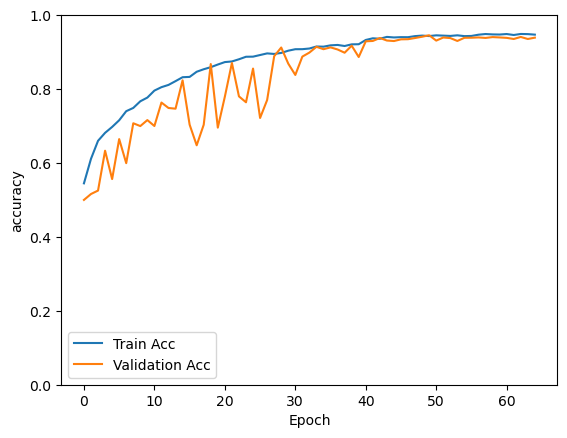

In [28]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.plot(hist['epoch'], hist['accuracy'], label='Train Acc')
    plt.plot(hist['epoch'], hist['val_accuracy'], label='Validation Acc')
    plt.ylim([0,1])
    plt.legend()
    plt.show()

plot_history(history)

# Save Model

In [29]:
model_json = model.to_json()
with open(str(Path(OUTPUT_MODEL, f'Model_{DIM}_{MODEL_NAME}.json')), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(str(Path(OUTPUT_MODEL, f"Model_{DIM}_{MODEL_NAME}.h5")))
print("Saved model to disk")

Saved model to disk


# Model Evaluate

In [30]:
test_lost, test_acc = model.evaluate(test_generator)

18/18 [==============================] - 9s 474ms/step - loss: 0.1383 - accuracy: 0.9427
